<a href="https://colab.research.google.com/github/vodkolav/DSlab1/blob/Colab/DSlab2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 submission
for course: Data Science lab 2   
by  Michael Berger   


Lecturer: Dr. Sharon Yalov-Handzel  
Afeka College of engineering


In [6]:

try:
  from google.colab import drive
  drive.mount('/content/drive',)
  pfx = "/content/drive/MyDrive/Studies/M.Sc/DSlab2"
  IN_COLAB = True
except:
  pfx = ""
  IN_COLAB = False

Mounted at /content/drive


## 1. Use the dataset from UCI Machine Learning Repository:
"Individual household electric power consumption" for performing time series analysis.  
https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [7]:
! pip install ucimlrepo
! pip install scikit-learn==1.4.2

In [8]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.utils import plot_model

import os
from datetime import datetime
import statistics as stat

import plotly.express as px
from plotly.subplots import make_subplots

from ucimlrepo import fetch_ucirepo , dotdict
pd.set_option('display.precision', 3)

from pathlib import Path
import pickle


In [9]:
fn = r"data/individual_household_electric_power_consumption.pkl"
pth = Path(pfx) / Path(fn)

In [10]:
if pth.exists():
    with open(pth, "rb") as fl:
        individual_household_electric_power_consumption = pickle.load(fl)
else:

    individual_household_electric_power_consumption = fetch_ucirepo(id=235)
    pth.parent.mkdir(parents=True, exist_ok=True)
    with open(pth, "wb") as fl:
        pickle.dump(individual_household_electric_power_consumption, fl)


In [11]:
# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# variable information
print(individual_household_electric_power_consumption.variables)

                    name     role         type demographic description units  \
0                   Date  Feature         Date        None        None  None   
1                   Time  Feature  Categorical        None        None  None   
2    Global_active_power  Feature   Continuous        None        None  None   
3  Global_reactive_power  Feature   Continuous        None        None  None   
4                Voltage  Feature   Continuous        None        None  None   
5       Global_intensity  Feature   Continuous        None        None  None   
6         Sub_metering_1  Feature   Continuous        None        None  None   
7         Sub_metering_2  Feature   Continuous        None        None  None   
8         Sub_metering_3  Feature   Continuous        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  


In [12]:
import json
# metadata
meta = json.dumps(individual_household_electric_power_consumption.metadata,indent=2)
print(meta)

{
  "uci_id": 235,
  "name": "Individual Household Electric Power Consumption",
  "repository_url": "https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption",
  "data_url": "https://archive.ics.uci.edu/static/public/235/data.csv",
  "abstract": "Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.",
  "area": "Physics and Chemistry",
  "tasks": [
    "Regression",
    "Clustering"
  ],
  "characteristics": [
    "Multivariate",
    "Time-Series"
  ],
  "num_instances": 2075259,
  "num_features": 9,
  "feature_types": [
    "Real"
  ],
  "demographics": [],
  "target_col": null,
  "index_col": null,
  "has_missing_values": "no",
  "missing_values_symbol": null,
  "year_of_dataset_creation": 2006,
  "last_updated": "Fri Mar 08 2024",
  "dataset_doi": "10.24432/C58K54",
  "creators": [
    "Georges Hebrail",
   

In [13]:
metadic = individual_household_electric_power_consumption.metadata

In [14]:
def mylen(o):
    if type(o)==int:
        return str(o)
    if type(o)==type(None):
        return "0"
    else:
        return len(o)

In [15]:
def showkeys(dic, ind = 0):
    if type(dic)== dotdict:
        for k,v  in dic.items() :
            print(" "*ind , k, "|", type(v).__name__, ",", mylen(v) )
            showkeys(dic[k], ind+4)

showkeys(metadic)

 uci_id | int , 235
 name | str , 47
 repository_url | str , 87
 data_url | str , 54
 abstract | str , 200
 area | str , 21
 tasks | list , 2
 characteristics | list , 2
 num_instances | int , 2075259
 num_features | int , 9
 feature_types | list , 1
 demographics | list , 0
 target_col | NoneType , 0
 index_col | NoneType , 0
 has_missing_values | str , 2
 missing_values_symbol | NoneType , 0
 year_of_dataset_creation | int , 2006
 last_updated | str , 15
 dataset_doi | str , 15
 creators | list , 2
 intro_paper | NoneType , 0
 additional_info | dotdict , 9
     summary | str , 780
     purpose | NoneType , 0
     funded_by | NoneType , 0
     instances_represent | NoneType , 0
     recommended_data_splits | NoneType , 0
     sensitive_data | NoneType , 0
     preprocessing_description | NoneType , 0
     variable_info | str , 913
     citation | NoneType , 0


In [16]:
print(metadic["abstract"])

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.


In [17]:
print(metadic["additional_info"]["summary"])

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes: 
1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


In [18]:
print(metadic["additional_info"]["variable_info"])

1.date: Date in format dd/mm/yyyy
2.time: time in format hh:mm:ss
3.global_active_power: household global minute-averaged active power (in kilowatt)
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5.voltage: minute-averaged voltage (in volt)
6.global_intensity: household global minute-averaged current intensity (in ampere)
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


## 2. Perform Exploratory Data Analysis (EDA) of the dataset:

First, convert all values to numeric

In [19]:
numcols = ['Global_active_power', 'Global_reactive_power',
           'Voltage', 'Global_intensity', 'Sub_metering_1',
           'Sub_metering_2', 'Sub_metering_3']

for c in numcols:
    X[c] = pd.to_numeric(X[c], errors = "coerce")

combine date and time into single col datetime

In [20]:
dt = X["Date"] + " " + X["Time"]
X["datetime"] = pd.to_datetime(dt, dayfirst=True)
X = X.set_index('datetime').drop(["Date","Time"],axis=1)

### a.  Visualize time series trends

In [21]:
def summary(df):
    nonnans = df.shape[0] - df.isna().sum()
    nonnansPrc = (nonnans / df.shape[0] * 100).apply("{0:.2f}%".format)
    sam = df.sample(1, random_state=42).squeeze()
    res = pd.DataFrame([sam.index, df.dtypes.astype(str), nonnans,
                        nonnansPrc, df.nunique(), sam]).transpose()
    res.columns = ["Column", "data type", "non-null values",
                   "non-null values %", "unique values", "example"]
    res.sort_values("unique values",ascending=False, inplace=True)
    return res

In [22]:
X.head()

Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [23]:

pd.options.display.float_format = '{:,.4f}'.format
d = X.describe()
d

Global_active_power  Global_reactive_power        Voltage  \
count       2,049,280.0000         2,049,280.0000 2,049,280.0000   
mean                1.0916                 0.1237       240.8399   
std                 1.0573                 0.1127         3.2400   
min                 0.0760                 0.0000       223.2000   
25%                 0.3080                 0.0480       238.9900   
50%                 0.6020                 0.1000       241.0100   
75%                 1.5280                 0.1940       242.8900   
max                11.1220                 1.3900       254.1500   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count    2,049,280.0000  2,049,280.0000  2,049,280.0000  2,049,280.0000  
mean             4.6278          1.1219          1.2985          6.4584  
std              4.4444          6.1530          5.8220          8.4372  
min              0.2000          0.0000          0.0000          0.0000  
25%              1.4000          0.0000          0.0000          0.0000  
50%              2.6000          0.0000          0.0000          1.0000  
75%              6.4000          0.0000          1.0000         17.0000  
max             48.4000         88.0000         80.0000         31.0000

In [24]:
summary(X)

Column data type non-null values non-null values %  \
0    Global_active_power   float64         2049280            98.75%   
2                Voltage   float64         2049280            98.75%   
1  Global_reactive_power   float64         2049280            98.75%   
3       Global_intensity   float64         2049280            98.75%   
4         Sub_metering_1   float64         2049280            98.75%   
5         Sub_metering_2   float64         2049280            98.75%   
6         Sub_metering_3   float64         2049280            98.75%   

  unique values  example  
0          4186   0.2560  
2          2837 242.0000  
1           532   0.1060  
3           221   1.2000  
4            88   0.0000  
5            81   0.0000  
6            32   1.0000

### b. Check for seasonality and cyclical patterns

- Analyze distribution of power consumption
- Identify and handle missing values or outliers

## 3. Implement a linear regression model to predict power consumption for the last three time periods:

extract a smaller set Xs for debugging  

In [25]:
# backup original dataset as data to re-process later
data = X.copy(deep=True)

#context = "DEBUG"
context = "RELEASE"
# debug and development values: take small chunk of data,
# few epochs and verbose output
if context == "DEBUG":
  n_sampls = 10000
  X = X.iloc[0:n_sampls,:]
  time_step = 12
  epochs = 2
  batch_size = 64
  verbose = 1
else:
  time_step = 12
  epochs = 15
  batch_size = 1024
  verbose = 1

### b. Prepare features (consider lag variables, time-based features)
features:
year
month
week
day
hour
every variable + 10 of it's lags

y's:
Global_active_power

In [26]:
# resample the data to fill the NaN values
#   Xs  or XL
df= X["Global_active_power"].resample("1min").mean().ffill().to_frame()
df

Global_active_power
datetime                                
2006-12-16 17:24:00               4.2160
2006-12-16 17:25:00               5.3600
2006-12-16 17:26:00               5.3740
2006-12-16 17:27:00               5.3880
2006-12-16 17:28:00               3.6660
...                                  ...
2010-11-26 20:58:00               0.9460
2010-11-26 20:59:00               0.9440
2010-11-26 21:00:00               0.9380
2010-11-26 21:01:00               0.9340
2010-11-26 21:02:00               0.9320

[2075259 rows x 1 columns]

In [27]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
tmp = scaler.fit_transform(df)
df["Global_active_power"] = tmp
df

Global_active_power
datetime                                
2006-12-16 17:24:00               0.3748
2006-12-16 17:25:00               0.4784
2006-12-16 17:26:00               0.4796
2006-12-16 17:27:00               0.4809
2006-12-16 17:28:00               0.3250
...                                  ...
2010-11-26 20:58:00               0.0788
2010-11-26 20:59:00               0.0786
2010-11-26 21:00:00               0.0780
2010-11-26 21:01:00               0.0777
2010-11-26 21:02:00               0.0775

[2075259 rows x 1 columns]

In [28]:
for i in range(1,time_step):
    lag = i
    df[f"Global_active_power.L{lag}"] = df["Global_active_power"].shift(lag)

df.dropna(inplace = True)
df

Global_active_power  Global_active_power.L1  \
datetime                                                           
2006-12-16 17:35:00               0.4831                  0.3958   
2006-12-16 17:36:00               0.4661                  0.4831   
2006-12-16 17:37:00               0.4700                  0.4661   
2006-12-16 17:38:00               0.3601                  0.4700   
2006-12-16 17:39:00               0.2995                  0.3601   
...                                  ...                     ...   
2010-11-26 20:58:00               0.0788                  0.0788   
2010-11-26 20:59:00               0.0786                  0.0788   
2010-11-26 21:00:00               0.0780                  0.0786   
2010-11-26 21:01:00               0.0777                  0.0780   
2010-11-26 21:02:00               0.0775                  0.0777   

                     Global_active_power.L2  Global_active_power.L3  \
datetime                                                              
2006-12-16 17:35:00                  0.3246                  0.3252   
2006-12-16 17:36:00                  0.3958                  0.3246   
2006-12-16 17:37:00                  0.4831                  0.3958   
2006-12-16 17:38:00                  0.4661                  0.4831   
2006-12-16 17:39:00                  0.4700                  0.4661   
...                                     ...                     ...   
2010-11-26 20:58:00                  0.0784                  0.0788   
2010-11-26 20:59:00                  0.0788                  0.0784   
2010-11-26 21:00:00                  0.0788                  0.0788   
2010-11-26 21:01:00                  0.0786                  0.0788   
2010-11-26 21:02:00                  0.0780                  0.0786   

                     Global_active_power.L4  Global_active_power.L5  \
datetime                                                              
2006-12-16 17:35:00                  0.3281                  0.3283   
2006-12-16 17:36:00                  0.3252                  0.3281   
2006-12-16 17:37:00                  0.3246                  0.3252   
2006-12-16 17:38:00                  0.3958                  0.3246   
2006-12-16 17:39:00                  0.4831                  0.3958   
...                                     ...                     ...   
2010-11-26 20:58:00                  0.0788                  0.0786   
2010-11-26 20:59:00                  0.0788                  0.0788   
2010-11-26 21:00:00                  0.0784                  0.0788   
2010-11-26 21:01:00                  0.0788                  0.0784   
2010-11-26 21:02:00                  0.0788                  0.0788   

                     Global_active_power.L6  Global_active_power.L7  \
datetime                                                              
2006-12-16 17:35:00                  0.3118                  0.3250   
2006-12-16 17:36:00                  0.3283                  0.3118   
2006-12-16 17:37:00                  0.3281                  0.3283   
2006-12-16 17:38:00                  0.3252                  0.3281   
2006-12-16 17:39:00                  0.3246                  0.3252   
...                                     ...                     ...   
2010-11-26 20:58:00                  0.0788                  0.0858   
2010-11-26 20:59:00                  0.0786                  0.0788   
2010-11-26 21:00:00                  0.0788                  0.0786   
2010-11-26 21:01:00                  0.0788                  0.0788   
2010-11-26 21:02:00                  0.0784                  0.0788   

                     Global_active_power.L8  Global_active_power.L9  \
datetime                                                              
2006-12-16 17:35:00                  0.4809                  0.4796   
2006-12-16 17:36:00                  0.3250                  0.4809   
2006-12-16 17:37:00                  0.3118                  0.3250   
2006-12-1

### a. Split the data into training and testing sets

In [29]:
# find appropriate train/test ratio for the data
td = df.index.max() - df.index.min()
td.days * 24 * 60

2075040

In [30]:
td.days / 30

48.03333333333333

In [31]:
X.shape

(2075259, 7)

In [32]:
1- (3 * 30 * 24 * 60 ) / X.shape[0]

0.9375499636430923

In [33]:
# Split the data into feature and target
target = "Global_active_power"
t = df[target]
P = df.drop(columns= target)
#Split the data into train and test sets
cutoff = int(len(P) * 0.94) # size of train
X_train, y_train = P[:cutoff], t[:cutoff]
X_test, y_test = P[cutoff:], t[cutoff:]

In [34]:
X_train.shape, X_test.shape

((1950733, 11), (124515, 11))

### c. Train the model and make predictions

In [35]:
LR_model = LinearRegression()
res = LR_model.fit(X_train, y_train)


In [36]:
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "LinearRegression": LR_model.predict(X_test).squeeze()
             })
df_pred_test

y_test  LinearRegression
datetime                                     
2010-09-01 09:48:00  0.0246            0.0263
2010-09-01 09:49:00  0.0373            0.0259
2010-09-01 09:50:00  0.0344            0.0395
2010-09-01 09:51:00  0.0244            0.0345
2010-09-01 09:52:00  0.0281            0.0249
...                     ...               ...
2010-11-26 20:58:00  0.0788            0.0785
2010-11-26 20:59:00  0.0786            0.0788
2010-11-26 21:00:00  0.0780            0.0789
2010-11-26 21:01:00  0.0777            0.0789
2010-11-26 21:02:00  0.0775            0.0782

[124515 rows x 2 columns]

In [37]:
def compare_preds(df):
    # compare predictions of different models
    # over a small (for performance) chunk of data
    df_pred_test = df[:10000]
    fig = px.line(df_pred_test, labels= {"value": "Powah!"},
              title = "Actual powah vs. Predicted powah.")
    return fig

In [38]:
compare_preds(df_pred_test)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


## 4. Evaluate the linear regression model using appropriate metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (R²) value

In [39]:
experiments = pd.DataFrame(columns=['model','data'])

In [40]:
def sqiz(y):
    # required to deal with higher dimensional outputs
    if len(y.shape)>2 and y.shape[2]>1:
        y = y[:,0,0]
    return y.squeeze()


def pipeline(model, x_train, y_train, x_test, y_test, model_args={}):

    # Train the model
    print(f"training model, please wait...")
    model.fit(x_train, y_train, **model_args) # , epochs=epochs, validation_split= .1, verbose=0)

    print(f"evaluating model, please wait...")
    y_trn_pred = model.predict(x_train)
    y_pred = model.predict(x_test, batch_size = batch_size)


    #TODO: Invert predictions back to original values range?
    # train_predict = scaler.inverse_transform(train_predict)
    # Y = scaler.inverse_transform([Y])

    #df_pred_test = pd.DataFrame({"y_test": y_test,"y_pred": y_pred})

    res = {}
    print("1) y_train.shape: ", y_train.shape,"| y_trn_pred.shape: ", y_trn_pred.shape)
    # Evaluate the model on train set
    y_train = sqiz(y_train)
    y_trn_pred = sqiz(y_trn_pred)
    print("2) y_train.shape: ", y_train.shape,"| y_trn_pred.shape: ", y_trn_pred.shape)

    # note: [] on rhs are required for converting to df later on
    res["trn_MAE"] = [mean_absolute_error(y_train, y_trn_pred)]
    res["trn_MSE"] = [mean_squared_error(y_train, y_trn_pred)]
    res["trn_RMSE"] = [root_mean_squared_error(y_train, y_trn_pred)]
    res["trn_Rsq"] = [r2_score(y_train, y_trn_pred)]

    print("1) y_test.shape: ", y_test.shape,"| y_pred.shape: ", y_pred.shape)
    # Evaluate the model on test set
    y_test = sqiz(y_test)
    y_pred = sqiz(y_pred)
    print("2) y_test.shape: ", y_test.shape,"| y_pred.shape: ", y_pred.shape)

    res["tst_MAE"] = [mean_absolute_error(y_test, y_pred)]
    res["tst_MSE"] = [mean_squared_error(y_test, y_pred)]
    res["tst_RMSE"] = [root_mean_squared_error(y_test, y_pred)]
    res["tst_Rsq"] = [r2_score(y_test, y_pred)]
    print("done")
    return model, res


In [41]:

def report(result, model_label, data_label):
    a = result
    a["model"] = model_label
    a["data"] = data_label
    log_df = pd.DataFrame(a)
    global experiments

    if((experiments.shape[0]>0) and
       model_label in experiments.model.unique() and
       data_label in experiments.data.unique()):
        import warnings
        warnings.warn(f"model label {model_label} and data label '{data_label}' already exist. replacing.")
        # TODO: either implement 2-label drop, or make label composite, e.g. "model_data"
        experiments[["model","data"]].head()
        #drop(fit_runs, 'data', label)

    experiments = pd.concat([experiments, log_df])

    metrics = list(result.keys())
    metrics.sort()

    log_df_melted = experiments.melt(id_vars=['model','data'],
                            value_vars= metrics, #['accuracy', 'loss'],
                            var_name='metric',
                            value_name='value')

    rx = r"(?P<set>[trns]+_)?(?P<metric>[A-Za-z]+)"
    nspl = log_df_melted.metric.str.extract(rx)
    log_df_melted.drop('metric',axis=1, inplace=True)
    log_df_melted = log_df_melted.join(nspl)
    log_df_melted.loc[log_df_melted.set == "trn_", "set"] = "trn"
    #log_df_melted.loc[log_df_melted.set == "val_", "set"] = "val"
    log_df_melted.loc[log_df_melted.set == "tst_", "set"] = "tst"

    fig = px.bar(log_df_melted, x='model', y='value', title= "use mouse to zoom",
                  color='set', facet_row='metric', height=600, barmode = 'group',
                  facet_col="data", category_orders={"set": ["trn","val","tst"]}
                 )

    #fig.update_yaxes(matches='facet_row')
    return fig

In [42]:
baseline_model = DummyRegressor(strategy='mean')

In [43]:
baseline_model, res = pipeline(baseline_model, X_train, y_train, X_test, y_test)

report(res, "Baseline", "basic")


training model, please wait...
evaluating model, please wait...
1) y_train.shape:  (1950733,) | y_trn_pred.shape:  (1950733,)
2) y_train.shape:  (1950733,) | y_trn_pred.shape:  (1950733,)
1) y_test.shape:  (124515,) | y_pred.shape:  (124515,)
2) y_test.shape:  (124515,) | y_pred.shape:  (124515,)
done


In [44]:
df_pred_test["baseline"] =  baseline_model.predict(X_test)

In [45]:
model = LinearRegression()

In [46]:
model, res = pipeline(model, X_train, y_train, X_test, y_test)
report(res, "LinearRegression", "basic")

training model, please wait...
evaluating model, please wait...
1) y_train.shape:  (1950733,) | y_trn_pred.shape:  (1950733,)
2) y_train.shape:  (1950733,) | y_trn_pred.shape:  (1950733,)
1) y_test.shape:  (124515,) | y_pred.shape:  (124515,)
2) y_test.shape:  (124515,) | y_pred.shape:  (124515,)
done


In [47]:
compare_preds(df_pred_test)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [48]:
experiments

model   data  trn_MAE  trn_MSE  trn_RMSE  trn_Rsq  tst_MAE  \
0          Baseline  basic   0.0741   0.0092    0.0959   0.0000   0.0682   
0  LinearRegression  basic   0.0088   0.0006    0.0237   0.9389   0.0079   

   tst_MSE  tst_RMSE  tst_Rsq  
0   0.0073    0.0856  -0.0003  
0   0.0004    0.0208   0.9409

## 5. Recurrent Neural Network (RNN)
Implement a Recurrent Neural Network (RNN) for power consumption prediction:

### a. Preprocess data for RNN input

In [49]:
df.shape

(2075248, 12)

In [50]:
# Split the data into feature and target
target = "Global_active_power"
t = df[target]
P = df.drop(columns= target)


#Split the data into train and test sets
X_train, y_train = P[:cutoff], t[:cutoff]
X_test, y_test = P[cutoff:], t[cutoff:]

### b. Design and train the RNN model

In [51]:
#sequence_length = X_train.shape[1]

# Build an RNN model
Rnn_model = Sequential([
    Input((time_step, 1)),
    SimpleRNN(units=32, activation='relu'),
    Dense(units=1)
])

Rnn_model.compile(optimizer='adam', loss='mse')
model_args = {"epochs":epochs, "batch_size":batch_size}

In [52]:
print(tf.config.list_physical_devices('GPU'))

[]


In [53]:
X_train.shape[0] / batch_size

1905.0126953125

In [54]:
Rnn_model, res = pipeline(Rnn_model, X_train, y_train, X_test, y_test, model_args)

training model, please wait...
Epoch 1/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0010
Epoch 2/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 5.5807e-04
Epoch 3/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 5.4910e-04
Epoch 4/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 5.5165e-04
Epoch 5/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 5.3583e-04
Epoch 6/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 5.3554e-04
Epoch 7/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 5.3361e-04
Epoch 8/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 5.3339e-04
Epoch 9/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 5.2761e-04
Epoch 10/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 5.2137e-04
Epoch 11/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 5.1514e-04
Epoch 12/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 5.1411e-04
Epoch 13/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 5.1643e

### c. Make predictions and visualize results  

 TODO: visualise the time series with predictions

In [55]:
df_pred_test["RNN"] =  Rnn_model.predict(X_test)

3892/3892 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [56]:
compare_preds(df_pred_test)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### d. Compare performance metrics with linear regression

In [57]:
report(res, "RNN", "basic")

## 6. Long Short-Term Memory (LSTM)
Implement Long Short-Term Memory (LSTM) for power consumption prediction:


### a. Preprocess data for LSTM input

In [58]:
# Split the data into feature and target
target = "Global_active_power"
t = df[[target]]
P = df.drop(columns= target)

#Split the data into train and test sets
X_train, y_train = P[:cutoff], t[:cutoff]
X_test, y_test = P[cutoff:], t[cutoff:]

In [59]:
X_train.shape, y_train.shape

((1950733, 11), (1950733, 1))

### b. Design and train the LSTM model

In [60]:
# Create and fit the LSTM network
LSTM_model = Sequential()
LSTM_model.add(Input((time_step, 1)))
LSTM_model.add(LSTM(50, return_sequences=True ))
LSTM_model.add(LSTM(50, return_sequences=False))
LSTM_model.add(Dense(1))

LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

model_args = {"epochs":epochs, "batch_size":batch_size, "verbose":verbose}

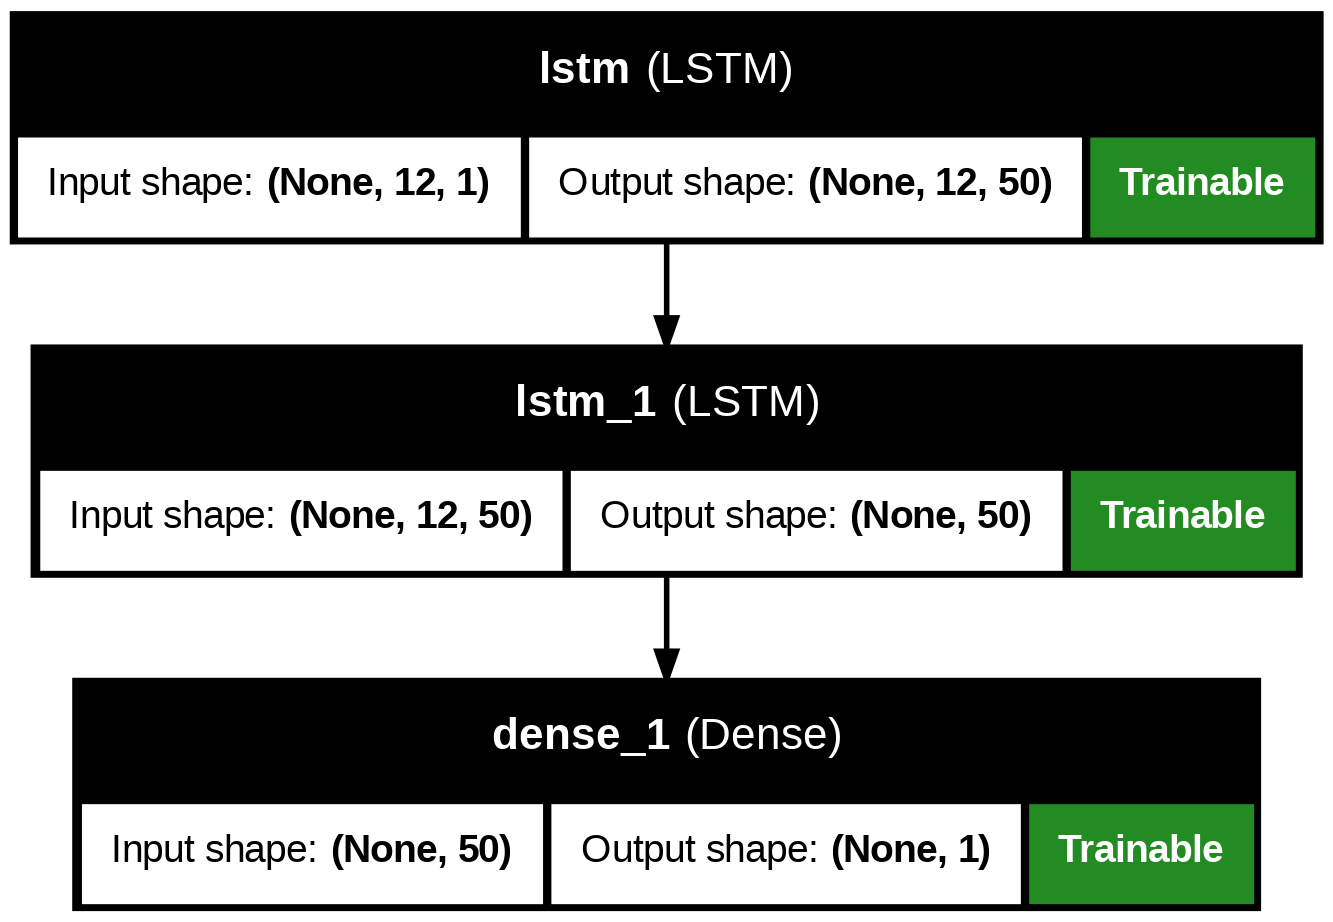

In [61]:
plot_model(LSTM_model ,
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=False,
    show_trainable=True)

In [62]:
model_args

{'epochs': 15, 'batch_size': 1024, 'verbose': 1}

In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1950733, 11), (1950733, 1), (124515, 11), (124515, 1))

In [64]:
LSTM_model, res = pipeline(LSTM_model, X_train, y_train, X_test, y_test, model_args)

training model, please wait...
Epoch 1/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 237s 122ms/step - loss: 0.0012
Epoch 2/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 265s 124ms/step - loss: 7.1354e-04
Epoch 3/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 261s 123ms/step - loss: 6.4653e-04
Epoch 4/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 260s 122ms/step - loss: 6.2032e-04
Epoch 5/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 260s 121ms/step - loss: 5.9478e-04
Epoch 6/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 267s 124ms/step - loss: 5.9945e-04
Epoch 7/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 224s 118ms/step - loss: 5.9114e-04
Epoch 8/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 232s 122ms/step - loss: 5.9349e-04
Epoch 9/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 257s 119ms/step - loss: 6.2278e-04
Epoch 10/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 260s 118ms/step - loss: 5.7898e-04
Epoch 11/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 262s 118ms/step - loss: 5.7243e-04
Epoch 12/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 259s 117ms/step - loss: 5.7967e-04
Epoch 13/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 260

### c. Make predictions and visualize results

In [65]:
df_pred_test["LSTM"] =  LSTM_model.predict(X_test)

3892/3892 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step


In [66]:
compare_preds(df_pred_test)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### d. Compare performance metrics with previous models

In [67]:
report(res, "LSTM", "basic")

## 7. LSTM with Attention
Implement an LSTM model with an Attention layer for power consumption prediction:

### a. Design and train the LSTM model with Attention

In [68]:
# initializing context length, goes to decoder
d = 4
# the rest is historical  context, goes to encoder

t    = df.iloc[:,0:d]
Xdec = df.iloc[:,1:(d+1)]
Xenc = df.iloc[:,(d+1):]

[Xenc.shape, Xdec.shape], t.shape

([(2075248, 7), (2075248, 4)], (2075248, 4))

In [69]:
#Split the data into train and test sets
X_train, y_train = [Xenc[:cutoff], Xdec[:cutoff]], t[:cutoff]
X_test , y_test  = [Xenc[cutoff:], Xdec[cutoff:]], t[cutoff:]

In [70]:
[X_train[0].shape, X_train[1].shape], y_train.shape

([(1950733, 7), (1950733, 4)], (1950733, 4))

In [71]:
# Attention-based Encoder-Decoder model

encoder_input = Input(shape=(Xenc.shape[1], 1), name= "encoder_input")
encoder_lstm = LSTM(32, return_sequences=True, name="encoder_lstm")(encoder_input)

decoder_input = Input(shape=(Xdec.shape[1], 1), name= "decoder_input")
decoder_lstm = LSTM(32, return_sequences=True, name="decoder_lstm")(decoder_input)

attention = Attention(name = "attention")([decoder_lstm, encoder_lstm])
combined = Concatenate(axis=-1)([decoder_lstm, attention])

output = Dense(1)(combined)

attention_model = Model(inputs=[encoder_input, decoder_input], outputs=output)
attention_model.compile(optimizer='adam', loss='mse')


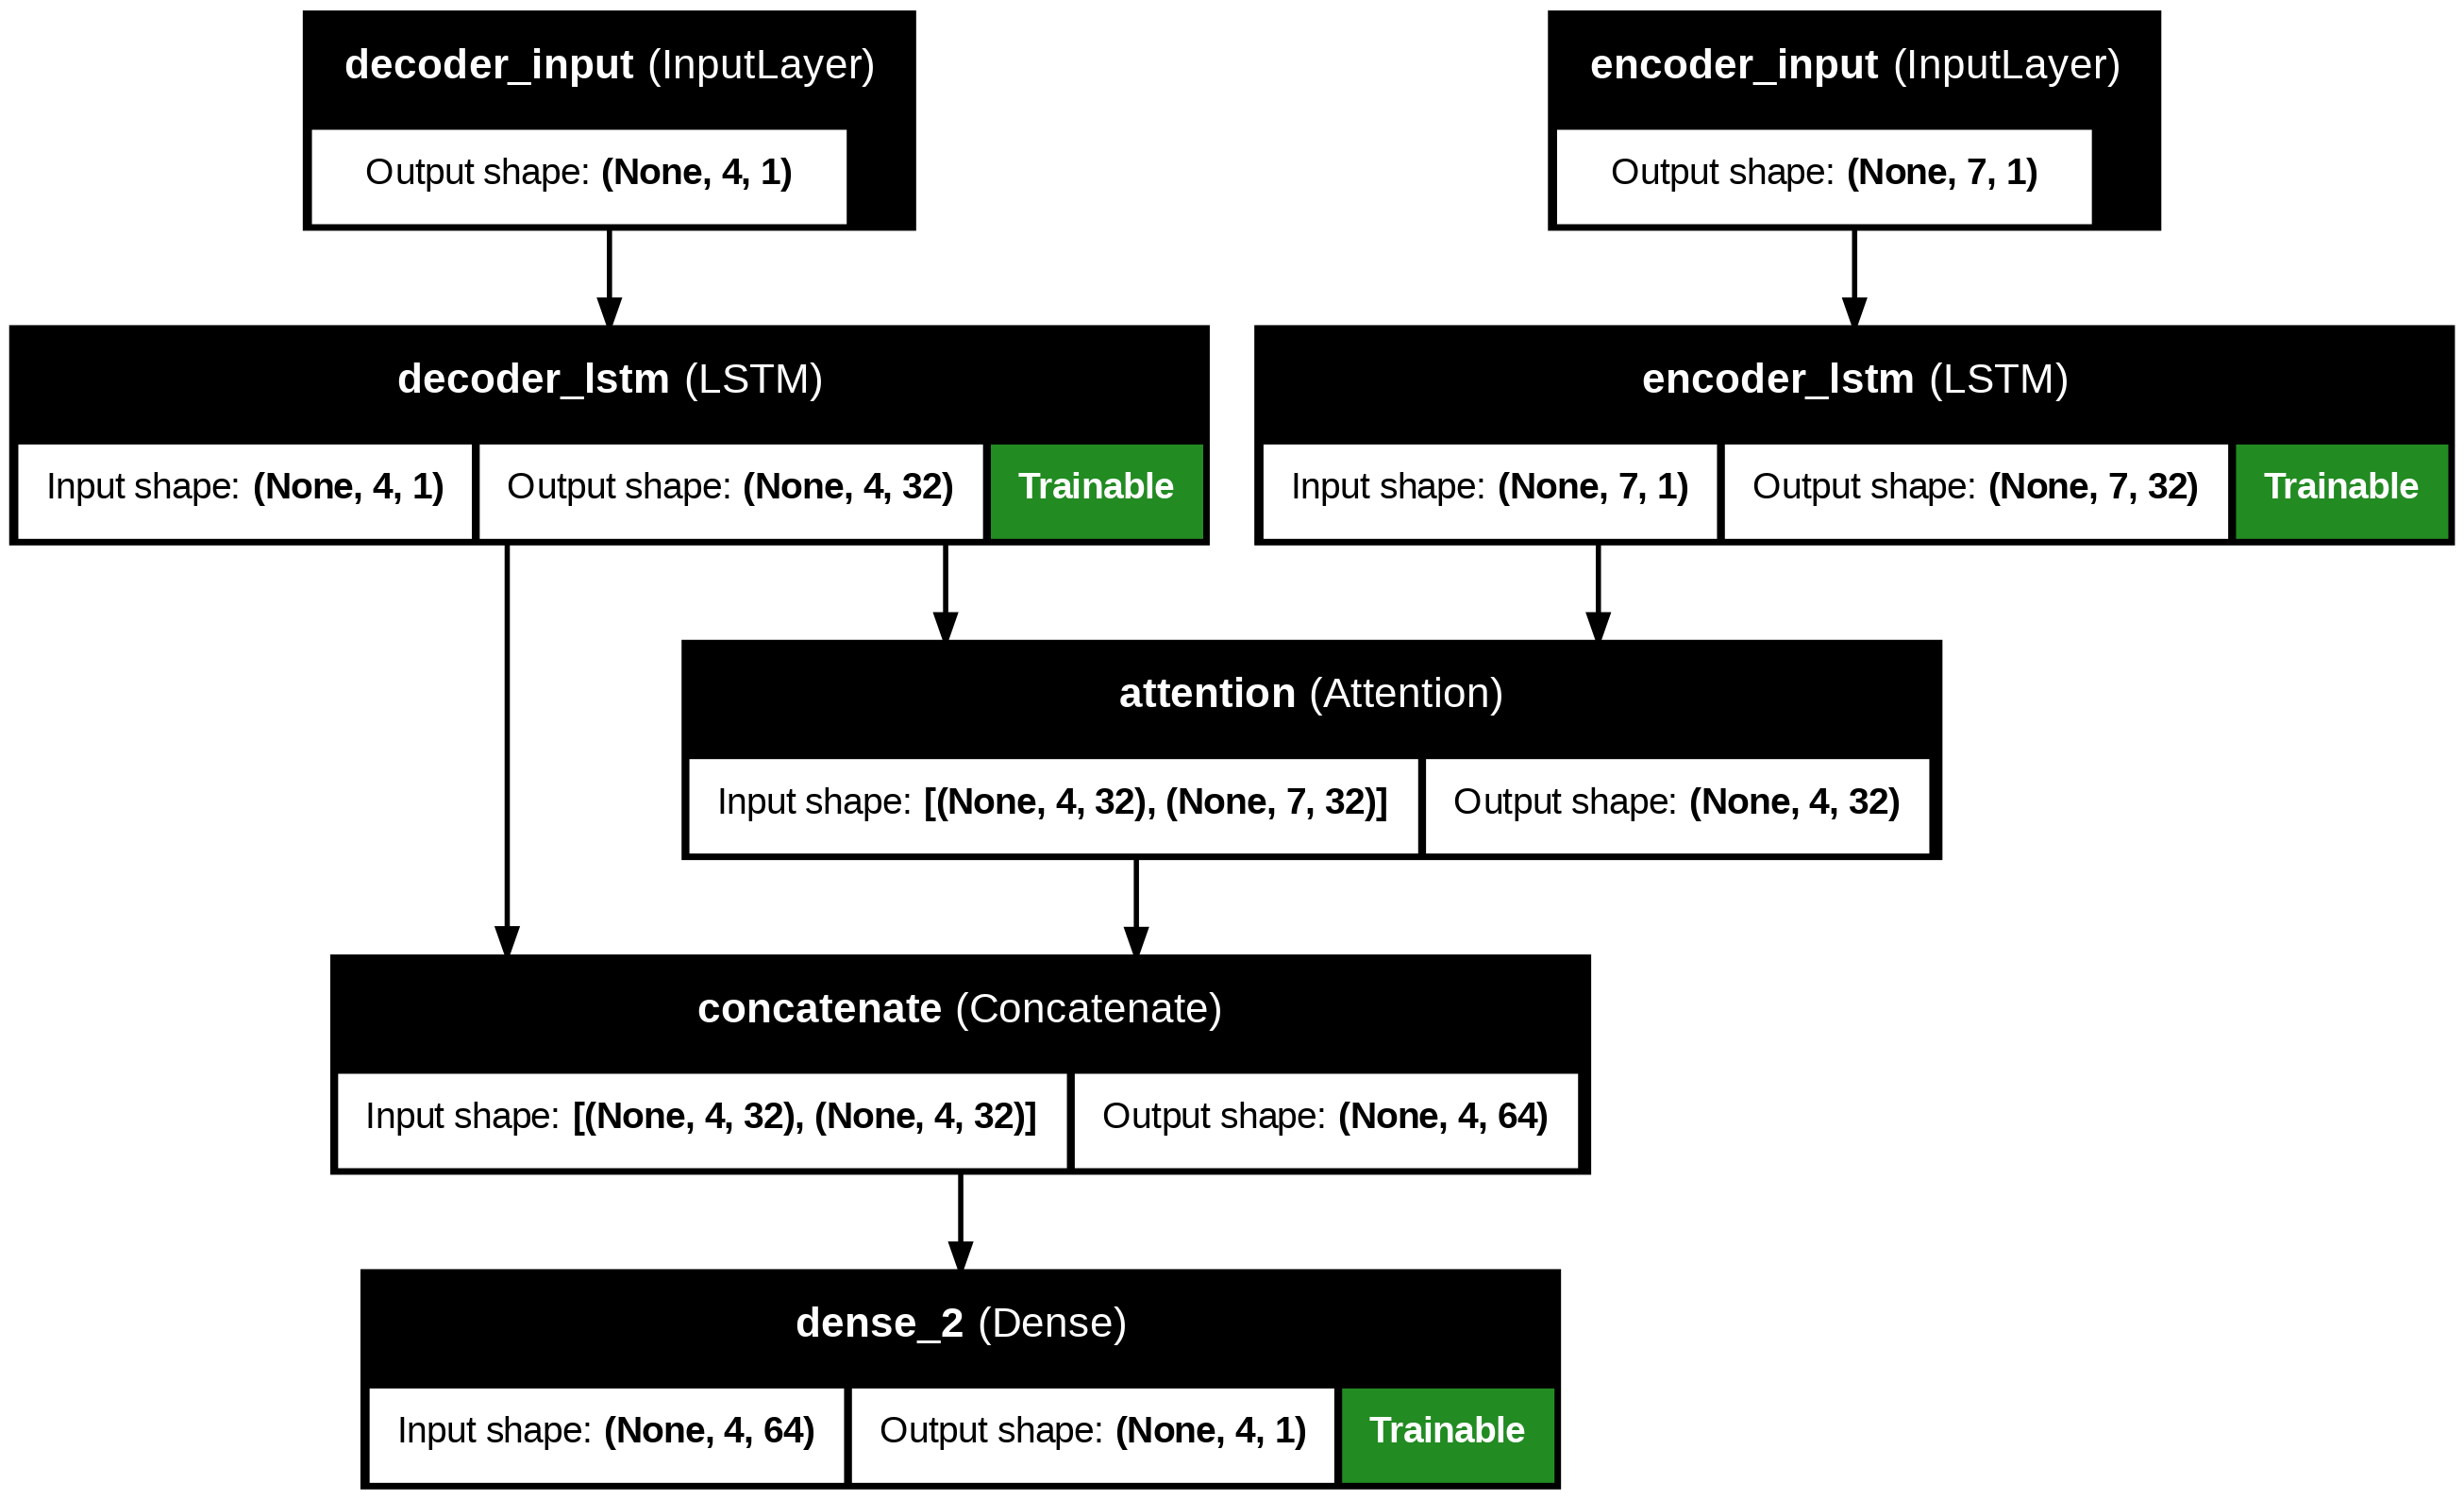

In [72]:

plot_model(attention_model,
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=False,
    show_trainable=True)

In [73]:
attention_model, res = pipeline(attention_model,
                                X_train, y_train,
                                X_test, y_test,
                                model_args)

training model, please wait...
Epoch 1/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 90s 46ms/step - loss: 0.0012
Epoch 2/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 137s 43ms/step - loss: 1.5739e-04
Epoch 3/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 87s 46ms/step - loss: 1.4521e-04
Epoch 4/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 142s 46ms/step - loss: 1.4461e-04
Epoch 5/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 142s 46ms/step - loss: 1.4235e-04
Epoch 6/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 140s 45ms/step - loss: 1.4340e-04
Epoch 7/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 140s 44ms/step - loss: 1.4448e-04
Epoch 8/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 85s 45ms/step - loss: 1.4333e-04
Epoch 9/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 142s 45ms/step - loss: 1.4321e-04
Epoch 10/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 85s 44ms/step - loss: 1.4406e-04
Epoch 11/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 144s 45ms/step - loss: 1.4414e-04
Epoch 12/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 142s 45ms/step - loss: 1.4360e-04
Epoch 13/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 86s 45ms/step - los

### b. Make predictions and visualize results

In [74]:
att_pred =  attention_model.predict(X_test)

3892/3892 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step


In [75]:
df_pred_test["ATTN"] = att_pred[:,0]

In [76]:
compare_preds(df_pred_test)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### c. Compare performance metrics with previous models

In [77]:
report(res, "LSTM+Attention", "basic")

### d. Analyze the Attention weights to interpret model focus

## 8. Data augmentation experiment:

### a. Modify up to 10% of the dataset to potentially improve prediction results
I did not understand how I should modify the dataset to improve results, so I just added another variable to the mix.

In [78]:
def preprocess(X, colname,  time_step = 12):
    df = X[colname].resample("1min").mean().ffill().to_frame()
    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    tmp = scaler.fit_transform(df)
    df[colname] = tmp

    for lag in range(1,time_step):
        df[f"{colname}.L{lag}"] = df[colname].shift(lag)

    df.dropna(inplace = True)
    return df

gap = preprocess(X, "Global_active_power")
grp = preprocess(X, "Global_reactive_power")
df = gap.join(grp)

### b. Retrain and evaluate all three models (RNN, LSTM, LSTM with Attention)

#### RNN

In [79]:
# Split the data into feature and target
target = "Global_active_power"
t = df[target]
P = df.drop(columns= target)

#Split the data into train and test sets
X_train, y_train = P[:cutoff], t[:cutoff]
X_test, y_test = P[cutoff:], t[cutoff:]

In [80]:
#sequence_length = X_train.shape[1]

# Build an RNN model
Rnn_model = Sequential([
    Input((X_train.shape[1], 1)),
    SimpleRNN(units=32, activation='relu'),
    Dense(units=1)
])

Rnn_model.compile(optimizer='adam', loss='mse')
model_args = {"epochs":epochs, "batch_size":batch_size}

In [81]:
Rnn_model, RNN_res = pipeline(Rnn_model, X_train, y_train, X_test, y_test, model_args)

training model, please wait...
Epoch 1/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 0.0021
Epoch 2/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 62s 29ms/step - loss: 5.7323e-04
Epoch 3/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 5.6688e-04
Epoch 4/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 5.6215e-04
Epoch 5/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 5.5743e-04
Epoch 6/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 5.5755e-04
Epoch 7/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 5.7766e-04
Epoch 8/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - loss: 5.4658e-04
Epoch 9/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 5.4791e-04
Epoch 10/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 5.4778e-04
Epoch 11/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 5.4462e-04
Epoch 12/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 5.4312e-04
Epoch 13/15
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 5.583

#### LSTM  
Requires slightly different preprocessing:

In [82]:
gap = np.expand_dims(gap.values, axis=2)
grp = np.expand_dims(grp.values, axis=2)
arr = np.concatenate([gap, grp], axis=2)

In [83]:
# Split the data into feature and target
t = arr[:,0,:]
P = arr[:,1:,:]
#Split the data into train and test sets
X_train, y_train = P[:cutoff], t[:cutoff]
X_test, y_test = P[cutoff:], t[cutoff:]

In [84]:
X_train.shape, y_train.shape

((1950733, 11, 2), (1950733, 2))

In [85]:
input_dim = X_train.shape[1:3]
input_dim

(11, 2)

In [86]:
# Create and fit the LSTM network
LSTM_model = Sequential()
LSTM_model.add(Input(input_dim))
LSTM_model.add(LSTM(50, return_sequences=True ))
LSTM_model.add(LSTM(50, return_sequences=False))
LSTM_model.add(Dense(input_dim[1]))

LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

model_args = {"epochs":epochs, "batch_size":32, "verbose":verbose}

In [87]:
LSTM_model, LSTM_res = pipeline(LSTM_model, X_train, y_train, X_test, y_test, model_args)

training model, please wait...
Epoch 1/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 899s 15ms/step - loss: 9.3713e-04
Epoch 2/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 908s 15ms/step - loss: 6.9949e-04
Epoch 3/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 910s 15ms/step - loss: 6.7127e-04
Epoch 4/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 907s 15ms/step - loss: 6.5726e-04
Epoch 5/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 934s 15ms/step - loss: 6.4762e-04
Epoch 6/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 923s 15ms/step - loss: 6.3784e-04
Epoch 7/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 982s 15ms/step - loss: 6.3111e-04
Epoch 8/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 986s 15ms/step - loss: 6.2188e-04
Epoch 9/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 916s 15ms/step - loss: 6.1497e-04
Epoch 10/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 925s 15ms/step - loss: 6.0372e-04
Epoch 11/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 920s 15ms/step - loss: 5.9862e-04
Epoch 12/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 914s 15ms/step - loss: 5.9108e-04
Epoch 13/15
60961/60961 ━━━━━━

#### LSTM with attention

In [88]:
# initial context length, goes to decoder
d = 4
# the rest is historical  context, goes to encoder

t    = arr[:,0:d]
Xdec = arr[:,1:(d+1)]
Xenc = arr[:,(d+1):]

t.shape, Xdec.shape, Xenc.shape

((2075248, 4, 2), (2075248, 4, 2), (2075248, 7, 2))

In [89]:

#Split the data into train and test sets

X_train, y_train = [Xenc[:cutoff], Xdec[:cutoff]], t[:cutoff]
X_test , y_test  = [Xenc[cutoff:], Xdec[cutoff:]], t[cutoff:]

In [90]:
[X_train[0].shape, X_train[1].shape], y_train.shape

([(1950733, 7, 2), (1950733, 4, 2)], (1950733, 4, 2))

In [91]:
[X_test[0].shape, X_test[1].shape], y_test.shape

([(124515, 7, 2), (124515, 4, 2)], (124515, 4, 2))

In [92]:
# Attention-based Encoder-Decoder model

encoder_input = Input(shape=Xenc.shape[1:3], name= "encoder_input")
encoder_lstm = LSTM(32, return_sequences=True, name="encoder_lstm")(encoder_input)

decoder_input = Input(shape=Xdec.shape[1:3], name= "decoder_input")
decoder_lstm = LSTM(32, return_sequences=True, name="decoder_lstm")(decoder_input)

attention = Attention(name = "attention")([decoder_lstm, encoder_lstm])
combined = Concatenate(axis=-1)([decoder_lstm, attention])

output = Dense(Xenc.shape[2])(combined)

attention_model = Model(inputs=[encoder_input, decoder_input], outputs=output)
attention_model.compile(optimizer='adam', loss='mse')
#, metrics= <keras.metrics.>[mean_squared_error, RootMeanSquaredError, mean_absolute_error, R2Score])


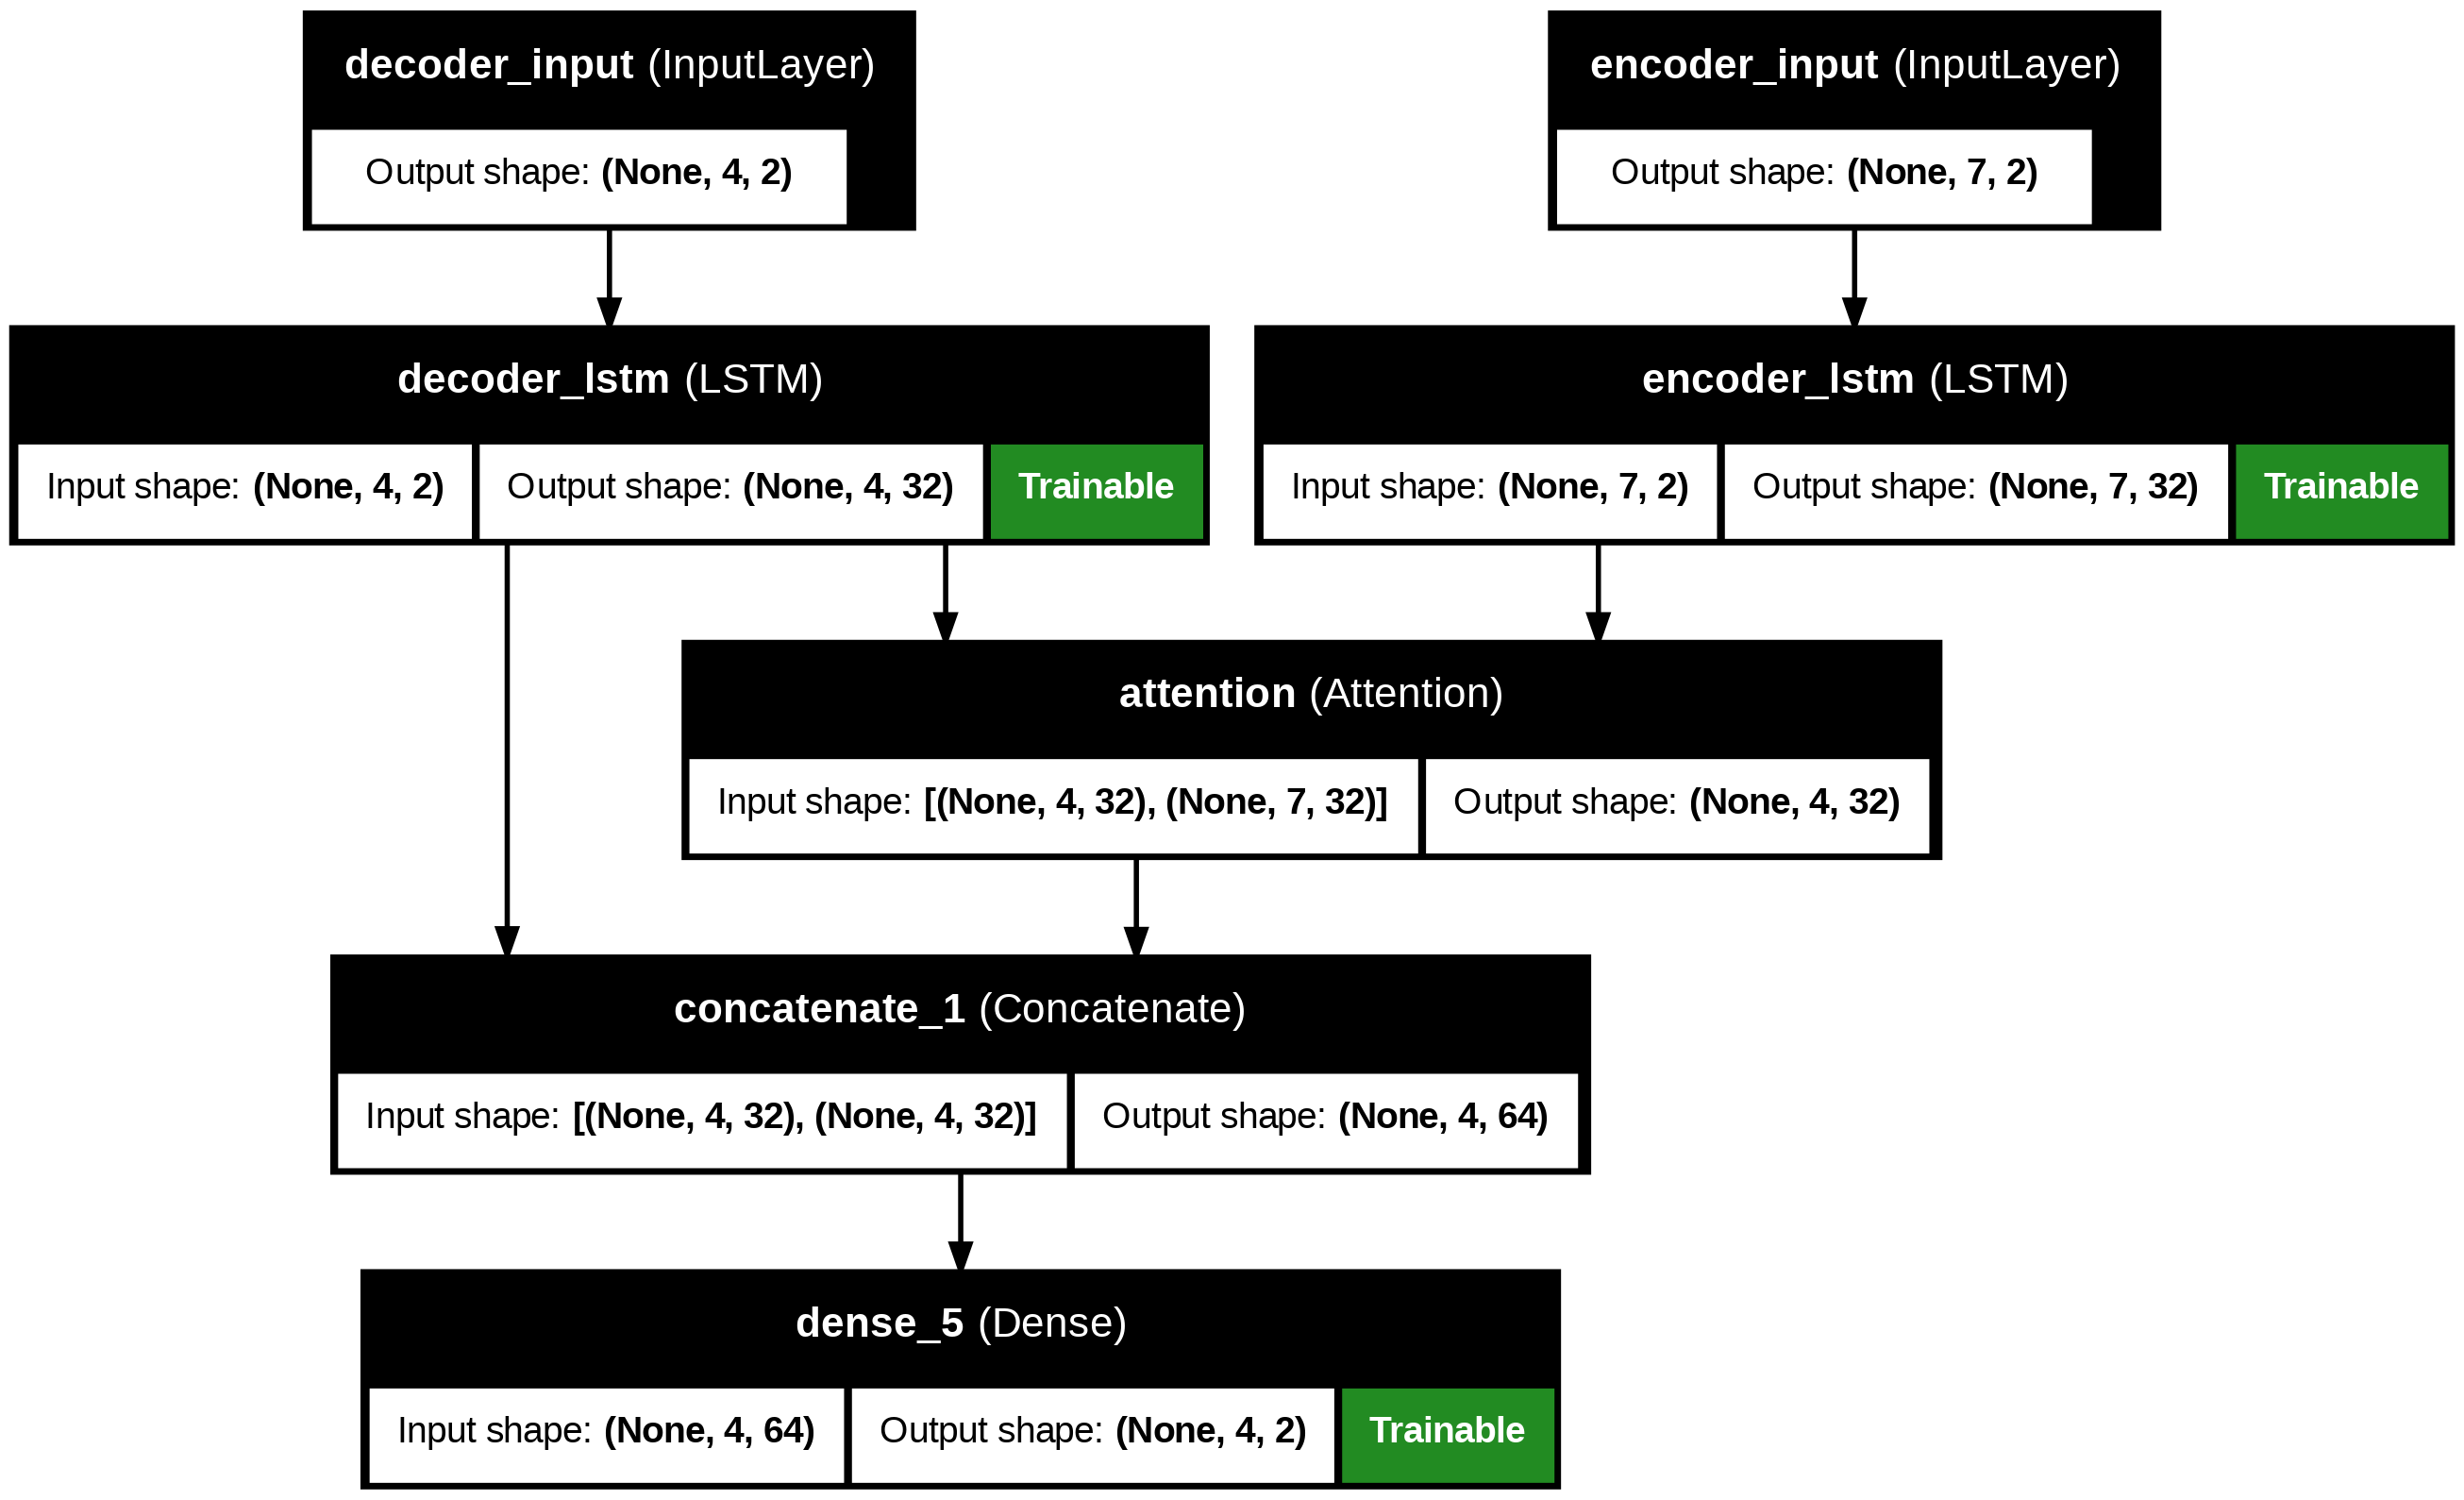

In [93]:
plot_model(attention_model ,
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=False,
    show_trainable=True)

In [94]:
attention_model, attention_res = pipeline(attention_model,
                                X_train, y_train,
                                X_test, y_test,
                                model_args)

training model, please wait...
Epoch 1/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 482s 8ms/step - loss: 3.1592e-04
Epoch 2/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 499s 8ms/step - loss: 1.7546e-04
Epoch 3/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 479s 8ms/step - loss: 1.7435e-04
Epoch 4/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 548s 9ms/step - loss: 1.7416e-04
Epoch 5/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 550s 8ms/step - loss: 1.7351e-04
Epoch 6/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 516s 8ms/step - loss: 1.7300e-04
Epoch 7/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 561s 8ms/step - loss: 1.7336e-04
Epoch 8/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 559s 8ms/step - loss: 1.7363e-04
Epoch 9/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 514s 8ms/step - loss: 1.7358e-04
Epoch 10/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 557s 8ms/step - loss: 1.7286e-04
Epoch 11/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 568s 8ms/step - loss: 1.7216e-04
Epoch 12/15
60961/60961 ━━━━━━━━━━━━━━━━━━━━ 568s 9ms/step - loss: 1.7278e-04
Epoch 13/15
60961/60961 ━━━━━━━━━━━━━━━━━━

### c. Compare the impact of data changes on each model's performance
  

In [95]:
report(RNN_res,  "RNN",  "augmented")
report(LSTM_res, "LSTM", "augmented")
report(attention_res, "LSTM+Attention", "augmented")

<ipython-input-41-650ba1e3a20d>:12: UserWarning:

model label LSTM and data label 'augmented' already exist. replacing.

<ipython-input-41-650ba1e3a20d>:12: UserWarning:

model label LSTM+Attention and data label 'augmented' already exist. replacing.



## 9. Data reduction experiment:

- Remove up to 10% of the data randomly
- Retrain and evaluate all three models
- Compare how data reduction affects each model's performance
## 10. Data resolution experiment:

- Reduce the time resolution of the data by 50% (e.g., from minute-level to 2-minute
intervals)
- Retrain and evaluate all three models
- Analyze how changes in data resolution impact each model's performance
## 11. Conclusion and insights:

- Summarize findings from all experiments
- Discuss which model performed best under different conditions
- Provide insights on the dataset's characteristics and their impact on model performance